# Hyperion fire detection - Boundary fire, manual samples

## 0. Load prerequisites, filepaths, libraries

Imports.

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import os.path
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
from pygaarst import raster
import brewer2mpl
import configs

In [2]:
import pandas as pd
import seaborn as sns

Set up plot options. 

In [3]:
sns.set_context('paper', font_scale=1.5)
sns.set_style('whitegrid')
font = {'family' : 'Corbel',
        'weight' : 'bold',
        'size'   : 24}

mpl.rc('font', **font)


Directory and file names.

In [4]:
configs.FIREPARAM

{'boundary': {'colbarpos': [0.125, 0.2, 0.725, 0.025],
  'figdim': (15, 19),
  'filedir': '2004Boundary',
  'firename': 'boundary',
  'fireyear': 2004,
  'infix': '_CLIP',
  'sceneid': 'EO1H0690142004201110PX'},
 'crazy': {'colbarpos': [0.125, 0.2, 0.725, 0.025],
  'figdim': (15, 19),
  'filedir': '2004Crazy',
  'firename': 'crazy',
  'fireyear': 2004,
  'infix': '_CLIP',
  'sceneid': 'EO1H0680132004192110KY'},
 'woodriver': {'colbarpos': [0.125, 0.125, 0.74, 0.02],
  'figdim': (15, 25),
  'filedir': '2009WoodRiver',
  'firename': 'woodriver',
  'fireyear': 2009,
  'infix': '_CLIP',
  'sceneid': 'EO1H0690142009214110KF'}}

In [5]:
basedir = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/HyspIRI_Prep_2014/"
outdir = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/HyspIRI_Prep_2014/visual/figures/"
firename = 'boundary'
firenamec = 'crazy'

## 1 Generate classifications

In [7]:
infns = {}
manual_samples = {}
rgbscenes = {}

In [9]:
rgbscenes['boundary'] = raster.GeoTIFF(os.path.join(basedir, 
        configs.FIREPARAM['boundary']['filedir'], configs.FIREPARAM['boundary']['sceneid'], 
        'EO1H0690142004201110PX_fc3_8bit_clip.tif'))
rgb753 = np.rollaxis(rgbscenes['boundary'].data, 0, 3)
rgbscenes['crazy'] = raster.GeoTIFF(os.path.join(basedir, 
        configs.FIREPARAM['crazy']['filedir'], configs.FIREPARAM['crazy']['sceneid'], 
        'EO1H0680132004192110KY_fc3_8bit_clip.tif'))
rgb753c = np.rollaxis(rgbscenes['crazy'].data, 0, 3)

In [41]:
colormapping = {
    'fire': 'yellow',
    'firescar': 'sienna',
    'vegetation': 'limegreen',
    'cloud': 'aqua',
    'smoke': 'aqua'
}

In [8]:
for fn in ['boundary', 'crazy']:
    infns[fn] = os.path.join(outdir, "%s_manual_samples.dat" % fn)
    manual_samples[fn] = pd.read_csv(infns[fn], sep='\t', comment='#')

Load buffer pixel, and fire pixel. Then merge. Filter out rows of all zero (these are from the no-data areas).

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
classifications = {}
classmapping = {'fire': 0, 'firescar': 1, 'vegetation': 2, 'cloud': 3, 'smoke': 3}

In [13]:
for fnm in [firenamec, firename]:
    print("loading all spectra for {}.".format(fnm))
    infn = os.path.join(
        "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/HyspIRI_Prep_2014/visual/tmp/{}_hullallspecs_calib.hdf5".format(
        fnm))
    with h5py.File(infn, "r") as infh:
        spectest = infh['spectrum'][...]
        i_buff = infh['i_row_idx'][...]
        j_buff = infh['j_col_idx'][...]
        wav = infh['bandwavelenght_nm'][...]
        bandnames = infh['bandname'][...]
    print("preprocessing relevant spectra as well as removing the saturated pixels")
    minspec = np.min(spectest, axis=0)
    nonnull = np.any(spectest > 0, axis=1)
    spectest = spectest[nonnull]
    i_buff = i_buff[nonnull]
    j_buff = j_buff[nonnull]
    saturationmask = np.any(spectest[:, 98:] > 100, axis=1)
    specs = spectest[~saturationmask, :]
    i_sat = i_buff[saturationmask]
    j_sat = j_buff[saturationmask]
    i_buff = i_buff[~saturationmask]
    j_buff = j_buff[~saturationmask]
    print("getting spectra of manually selected pixels: {}".format(len(manual_samples[fnm])))
    hypsc = raster.Hyperionscene(os.path.join(basedir, 
        configs.FIREPARAM[fnm]['filedir'], configs.FIREPARAM[fnm]['sceneid']))
    hypsc.infix = '_CLIP'
    manual_spectra = [
        hypsc.spectrum(row['ii'], row['jj'], bands='calibrated') for _, row in manual_samples[fnm].iterrows()]
    manual_spectra = np.array(manual_spectra)
    manual_samples[fnm]['class'] = manual_samples[fnm]['type'].map(classmapping)
    print('random forest classifier')
    clf = RandomForestClassifier(max_depth=4, n_estimators=100, max_features=1, random_state=100)
    clf = clf.fit(manual_spectra, manual_samples[fnm]['class'].values)
    print('fit spectra from larger area')
    prediction  = clf.predict(specs)
    classifications[fnm] = 4 * np.ones(rgbscenes[fnm].data.shape[1:], dtype='int')
    classifications[fnm][i_sat, j_sat] = 0
    for ii, pred in enumerate(prediction):
        classifications[fnm][i_buff[ii], j_buff[ii]] = prediction[ii]

INFO:root:The value 2004 192 21:07:57 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:root:The value 2004 192 21:09:12 couldn't be parsed as int, float, date, time, datetime. Returning it as string.


loading all spectra for crazy.
preprocessing relevant spectra as well as removing the saturated pixels
getting spectra of manually selected pixels: 100
random forest classifier
fit spectra from larger area


INFO:root:The value 2004 201 21:02:11 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:root:The value 2004 201 21:03:21 couldn't be parsed as int, float, date, time, datetime. Returning it as string.


loading all spectra for boundary.
preprocessing relevant spectra as well as removing the saturated pixels
getting spectra of manually selected pixels: 70
random forest classifier
fit spectra from larger area


## 2 Some cross-validation

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    manual_spectra, manual_samples['boundary']['class'].values, test_size=0.4, random_state=0)

In [64]:
for _ in itertools.repeat(None, 20):
    X_train, X_test, y_train, y_test = train_test_split(
        manual_spectra, manual_samples['boundary']['class'].values, test_size=0.4, random_state=0)
    clf = clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))

0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286
0.964285714286


In [65]:
scores = cross_val_score(
    clf, manual_spectra, manual_samples['boundary']['class'].values, cv=10, scoring='f1_macro')

In [66]:
print("F1 score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1 score: 0.97 (+/- 0.11)


In [67]:
scores = cross_val_score(
    clf, manual_spectra, manual_samples['boundary']['class'].values, cv=10, scoring='accuracy')

In [68]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.97 (+/- 0.11)


## 3 Save classifications to file

In [169]:
for fnm in ['crazy', 'boundary']:
    hypsc = raster.Hyperionscene(os.path.join(basedir, 
        configs.FIREPARAM[fnm]['filedir'], configs.FIREPARAM[fnm]['sceneid']))
    hypsc.infix = '_CLIP'
    classification_ds = hypsc.band220.clone(os.path.join(
        outdir, '%s_random_forest_extraction.tif' % fnm), classifications[fnm].astype('int32'))

INFO:root:The value 2004 192 21:07:57 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:root:The value 2004 192 21:09:12 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:pygaarst.geotiff:int32
INFO:pygaarst.geotiff:{'complex128': 11, 'uint32': 4, 'uint16': 2, 'float32': 6, 'complex64': 10, 'int32': 5, 'float64': 7, 'uint8': 1, 'int16': 3, 'int8': 1}
INFO:pygaarst.geotiff:5
INFO:root:The value 2004 201 21:02:11 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:root:The value 2004 201 21:03:21 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:pygaarst.geotiff:int32
INFO:pygaarst.geotiff:{'complex128': 11, 'uint32': 4, 'uint16': 2, 'float32': 6, 'complex64': 10, 'int32': 5, 'float64': 7, 'uint8': 1, 'int16': 3, 'int8': 1}
INFO:pygaarst.geotiff:5


In [170]:
test = raster.GeoTIFF(os.path.join(
        outdir, 'crazy_random_forest_extraction.tif'))

In [173]:
test.data

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ..., 
       [4, 4, 2, ..., 4, 4, 4],
       [4, 4, 2, ..., 4, 4, 4],
       [4, 2, 2, ..., 4, 4, 4]], dtype=int32)

## 4 Plot classification, after freshly loading from file

In [6]:
rgbscenes = {}
classifications = {}
manual_samples = {}

In [75]:
rgbscenes['boundary'] = raster.GeoTIFF(os.path.join(basedir, 
        configs.FIREPARAM['boundary']['filedir'], configs.FIREPARAM['boundary']['sceneid'], 
        'EO1H0690142004201110PX_fc3_8bit_clip.tif'))
rgb753 = 2 * np.rollaxis(rgbscenes['boundary'].data, 0, 3)
rgbscenes['crazy'] = raster.GeoTIFF(os.path.join(basedir, 
        configs.FIREPARAM['crazy']['filedir'], configs.FIREPARAM['crazy']['sceneid'], 
        'EO1H0680132004192110KY_fc3_8bit_clip.tif'))
rgb753c = np.rollaxis(rgbscenes['crazy'].data, 0, 3)

In [73]:
rgb753c.dtype

dtype('uint8')

In [66]:
for firename in  ['boundary', 'crazy']:
    classifications[firename] = raster.GeoTIFF(os.path.join(
        basedir, configs.FIREPARAM[firename]['filedir'], '{}_random_forest_extraction.tif'.format(firename))).data
    infn = os.path.join(basedir, configs.FIREPARAM[firename]['filedir'], "{}_manual_samples.dat".format(firename))
    manual_samples[firename] = pd.read_csv(infn, sep='\t', comment='#')

In [58]:
colormapping = {
    'fire': 'yellow',
    'firescar': 'sienna',
    'vegetation': 'limegreen',
    'cloud': 'aqua',
    'smoke': 'aqua'
}

In [59]:
ncl = 4
colors = ['yellow', 'sienna', 'limegreen', 'aqua', 'white']
cmap = mpl.colors.ListedColormap(colors)
bounds = range(ncl+2)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
labels = np.arange(0, ncl+1, 1)
labeltext = ['fire', 'firescar', 'vegetation', 'smoke/cloud', 'background']
loc = labels + .5

In [60]:
sns.set_context('paper')
sns.set_style('white', {"axes.facecolor": "1", "axes.grid": False})
font = {'family' : 'Corbel',
        'weight' : 'bold',
        'size'   : 24}

mpl.rc('font', **font)

In [61]:
classifications['crazy'].shape

(125, 210)

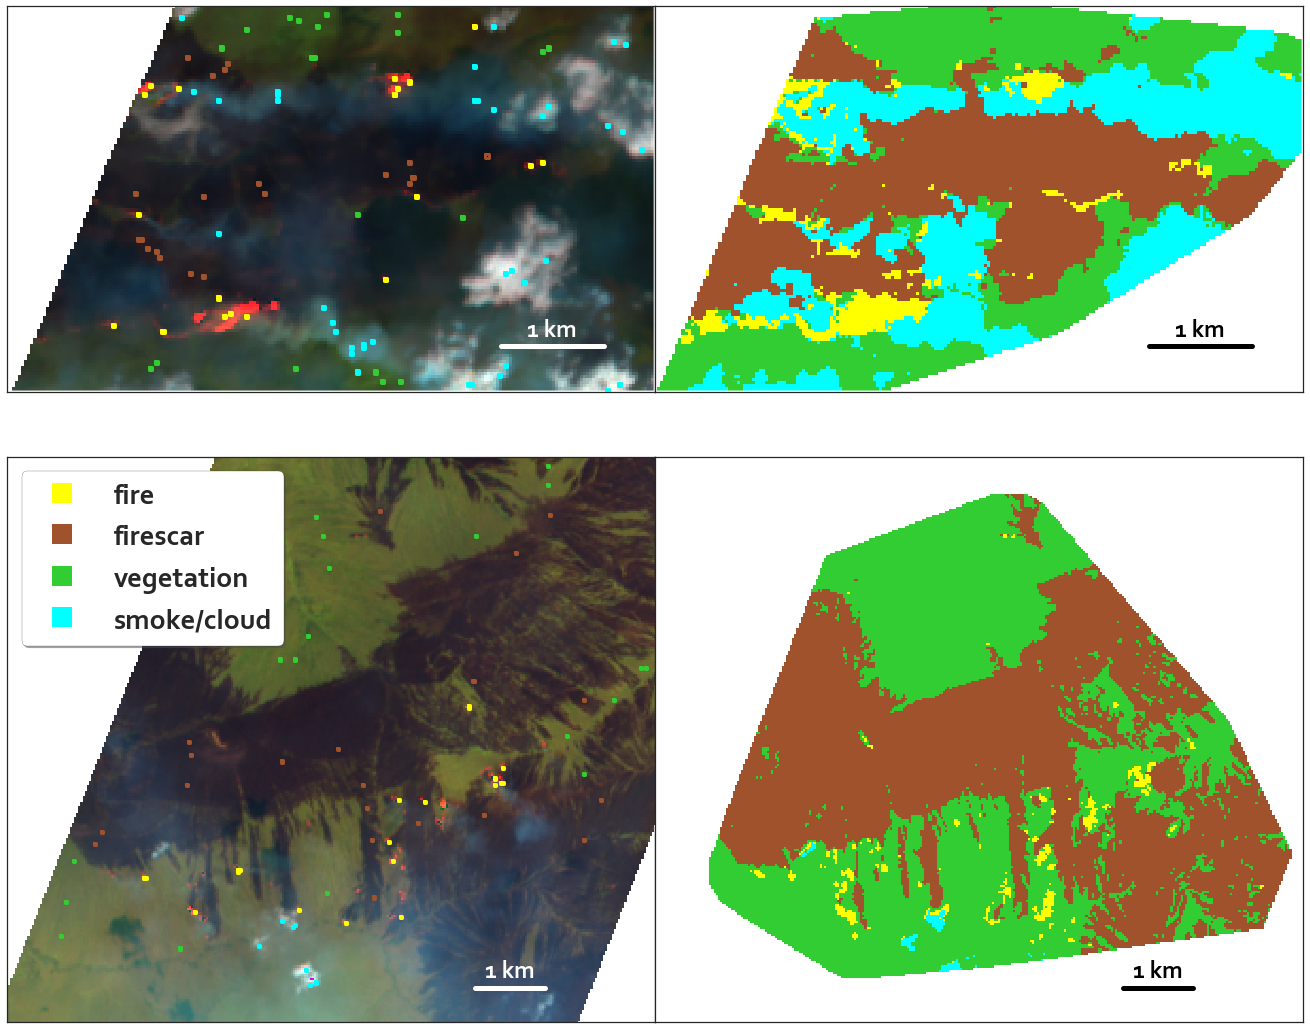

In [76]:
fig = plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1, 1],
                       height_ratios=[20, 25],
                       hspace=0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_aspect('equal')
    ax.grid(False)
    ax.axhline(linewidth=2, color="darkgrey") 
    ax.axvline(linewidth=2, color="k") 
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
implot1 = ax1.imshow(rgb753c, 
          interpolation='none')
for _, row in manual_samples['crazy'].iterrows():
    boxii = [row['ii'], row['ii'], row['ii']+1, row['ii']+1, row['ii']]
    boxjj = [row['jj'], row['jj']+1, row['jj']+1, row['jj'], row['jj']]
    ax1.plot(boxjj, boxii, color=colormapping[row['type']], 
            linewidth=3, zorder=5,
    )
implot1.set_clim(0.1,1)
ax2.imshow(classifications['crazy'], cmap=cmap, norm=norm, interpolation='none')

ax3.imshow(rgb753, vmax=125,
          interpolation='none', clim=(0., 0.5))
for _, row in manual_samples['boundary'].iterrows():
    boxii = [row['ii'], row['ii'], row['ii']+1, row['ii']+1, row['ii']]
    boxjj = [row['jj'], row['jj']+1, row['jj']+1, row['jj'], row['jj']]
    ax3.plot(boxjj, boxii, color=colormapping[row['type']], 
            linewidth=3, zorder=5,
    )
ax4.imshow(classifications['boundary'], cmap=cmap, norm=norm, interpolation='none')

# custom legend using dummy artist

simArtists = [ plt.Line2D((0,1),(0,0), color=couleur, marker='s', markersize=20, linestyle='') 
              for couleur in colors[:-1]]
simLabels = labeltext

ax3.legend(simArtists, simLabels, loc=2, 
            fontsize='large',
            frameon=True, fancybox=True, shadow=True)

# Scale bars
ax1.plot([160, 193.33], [110, 110], color='w', lw=5)
ax1.text(176.5, 105, 
         '1 km', 
          ha="center", va="center", 
          color='w')
ax2.plot([160, 193.33], [110, 110], color='k', lw=5)
ax2.text(176.5, 105, 
         '1 km', 
          ha="center", va="center", 
          color='black')
ax3.plot([220, 253.33], [250, 250], color='w', lw=5)
ax3.text(236.5, 242, 
         '1 km', 
          ha="center", va="center", 
          color='w')
ax4.plot([220, 253.33], [250, 250], color='k', lw=5)
ax4.text(236.5, 242, 
         '1 km', 
          ha="center", va="center", 
          color='black')

for ax in [ax3, ax4]:
    ax.set_ylim([266, 0])
    ax.set_xlim([0, 305])
for ax in [ax1, ax2]:
    ax.set_ylim([classifications['crazy'].shape[0], 0])
    ax.set_xlim([0, classifications['crazy'].shape[1]])

gs.update(wspace=0, hspace=0)
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
fig.tight_layout(pad=0, h_pad=0, w_pad=0)
fig.subplots_adjust(wspace=0, hspace=0)

In [77]:
outfn = 'Fig04_LR.jpg'
fig.savefig(os.path.join(outdir, outfn), dpi=150, bb_inches='tight')

In [27]:
print(fig.subplotpars.hspace, fig.subplotpars.wspace, sep='; ')

0; 0


(0, 305)

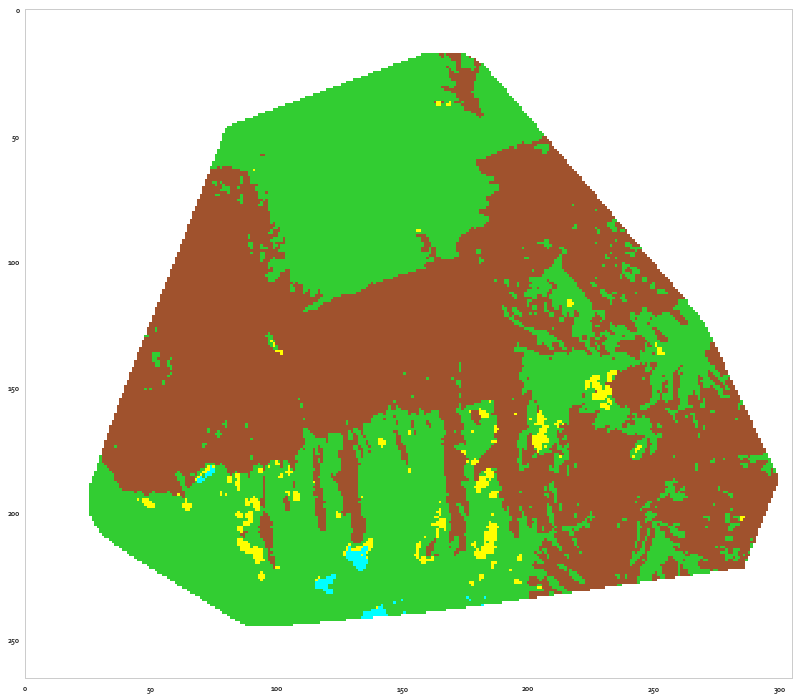

In [53]:
fig, ax1= plt.subplots(figsize=(15, 10))
ax1.set_aspect('equal')
#plt.axis('off')
ax1.grid(False)
plt.tight_layout()
plt.imshow(classifications['boundary'], cmap=cmap, norm=norm, interpolation='none')
#cb = plt.colorbar(orientation='horizontal', pad=0.05, shrink=0.84)
#cb.set_ticks(loc)
#cb.set_ticklabels(labeltext)

ax1.set_ylim([266, 0])
ax1.set_xlim([0, 305])

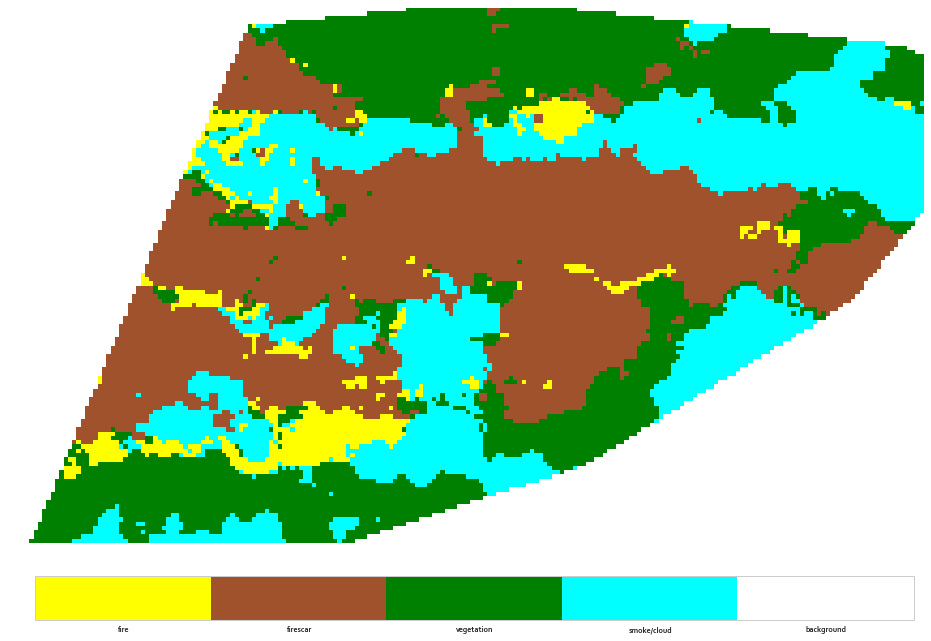

In [156]:
fig, ax1= plt.subplots(figsize=(15, 10))
ax1.set_aspect('equal')
plt.axis('off')
ax1.grid(False)
plt.tight_layout()

plt.imshow(classifications['crazy'], cmap=cmap, norm=norm, interpolation='none')
cb = plt.colorbar(orientation='horizontal', pad=0.05, shrink=0.84)
cb.set_ticks(loc)
cb.set_ticklabels(labeltext)

## Plot CIBR

In [3]:
b183 = {}
b185 = {}
b188 = {}
cibrmap = {}

In [6]:
for fnm in ['crazy', 'boundary']:
    hypsc = raster.Hyperionscene(os.path.join(basedir, 
        configs.FIREPARAM[fnm]['filedir'], configs.FIREPARAM[fnm]['sceneid']))
    hypsc.infix = '_CLIP'
    b183[fnm] = hypsc.band183.data.astype('float')
    b185[fnm] = hypsc.band185.data.astype('float')
    b188[fnm] = hypsc.band188.data.astype('float')

INFO:root:The value 2004 192 21:07:57 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:root:The value 2004 192 21:09:12 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:root:The value 2004 201 21:02:11 couldn't be parsed as int, float, date, time, datetime. Returning it as string.
INFO:root:The value 2004 201 21:03:21 couldn't be parsed as int, float, date, time, datetime. Returning it as string.


In [8]:
def co2cibr(h1, h2, low):
    return low / (0.6667*h1 + 0.3333*h2)

In [9]:
for fnm in ['crazy', 'boundary']:
    cibrmap[fnm] = co2cibr(b183[fnm], b188[fnm], b185[fnm])
    cibrmap[fnm] = np.nan_to_num(cibrmap[fnm])

/Users/cwaigl/anaconda2/envs/snakes/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


In [10]:
import matplotlib.colors as colors

In [11]:
sns.set_context('paper', font_scale=1.8)

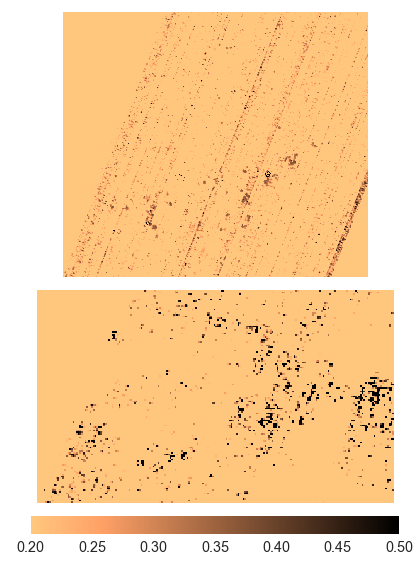

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 10))

for ax in [ax1, ax2]:
    ax.set_aspect('equal')
    ax.axis('off')
    ax.grid(False)

boundaryplot = ax1.imshow(cibrmap['boundary'], interpolation='none', vmin=0.2, vmax=0.5, cmap='copper_r')
crazyplot = ax2.imshow(cibrmap['crazy'], interpolation='none', vmin=0.4, vmax=0.5, cmap='copper_r')
ax1.set_ylim([266, 0])
ax1.set_xlim([0, 305])
cb = plt.colorbar(boundaryplot, orientation='horizontal', pad=0.05, shrink=0.44)
plt.subplots_adjust(hspace=0.05)


In [79]:
sns.set_context('paper', font_scale=2.5)
sns.set_style('white', {"axes.facecolor": "1", "axes.grid": False})
font = {'family' : 'Corbel',
        'weight' : 'bold',
        'size'   : 24}

mpl.rc('font', **font)

In [196]:
np.min(out)

0.0